In [23]:
# stop here

# Suppress warnings
import logging
import warnings
warnings.filterwarnings('ignore')

# Suppress specific logger warnings
logging.getLogger('natten.functional').setLevel(logging.ERROR)
import numpy as np

from PIL import Image
import os
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('inferno')
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.npya as data
import torch.optim as optim
## Torchvision
import torchvision
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from datasets import load_dataset
from torchvision import transforms
from transformers import ViTImageProcessor, DinatForImageClassification, ViTForImageClassification, ConvNextV2ForImageClassification, AutoImageProcessor,  ViTHybridForImageClassification, BeitForImageClassification

from torchvision.transforms import (Compose,
                                    Resize,
                                    ToTensor)


pathdir = r'/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LOSO_FOLD/IEMO_006/test_[937]'
Filterval = True

model_path = os.path.join(pathdir, 'model')

processor_path = os.path.join(pathdir, 'processor')
# model_state_dict_path = r"D:\Documents\MASC\vIT\ViT\Pretrain_Finetune\Vit_001.pth"

if Filterval==True:
    EMOTIONS = {
        0: 'neutral',
        1: 'happy',
        2: 'sad',
        3: 'angry',
        }
    Map2Num = {
        'neutral': 0,
        'happy': 1,
        'sad': 2,
        'angry': 3,
    }
else:
    EMOTIONS = {
        0: 'neutral',
        1: 'happy',
        2: 'sad',
        3: 'angry',
        4: 'fear',
        5: 'disgust',
    }
    Map2Num = {
        'neutral': 0,
        'happy': 1,
        'sad': 2,
        'angry': 3,
        'fear': 4,
        'disgust': 5
    }

 ########################## ViT ###############################
# processor = ViTImageProcessor.from_pretrained(processor_path)
# model = ViTForImageClassification.from_pretrained(model_path)#, id2label=EMOTIONS, label2id=Map2Num, ignore_mismatched_sizes=True, problem_type="single_label_classification")

########################## DINAT ###############################
processor = AutoImageProcessor.from_pretrained(processor_path)
model = DinatForImageClassification.from_pretrained(model_path, id2label=EMOTIONS, label2id=Map2Num, ignore_mismatched_sizes=True)

########################## CONVNEXTV2 ###############################
# processor = AutoImageProcessor.from_pretrained(processor_path)
# model = ConvNextV2ForImageClassification.from_pretrained(model_path, id2label=EMOTIONS, label2id=Map2Num, ignore_mismatched_sizes=True)



########################## Hybrid ViT ###############################
# processor = AutoImageProcessor.from_pretrained(processor_path)
# model = ViTHybridForImageClassification.from_pretrained(model_path, id2label=EMOTIONS, label2id=Map2Num, ignore_mismatched_sizes=True)


########################## BEIT ###############################

# processor = AutoImageProcessor.from_pretrained(processor_path)
# model = BeitForImageClassification.from_pretrained(model_path ,id2label=EMOTIONS, label2id=Map2Num,  ignore_mismatched_sizes=True)

# model.load_state_dict(torch.load(model_state_dict_path))
new_size = 224
_val_transforms = Compose(
        [
            Resize((new_size, new_size)),
            # Resize(size),
            # CenterCrop(size),
            ToTensor(),
            # normalize,
        ]
    )


def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)
def compute_predictions(model, inputs):
    # inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    return probabilities.cpu().numpy()



from datasets import load_dataset
cmapval = 'PuBuGn'


<Figure size 640x480 with 0 Axes>

In [24]:

def plot_matrix(labels, predictions, dataset, acc, uar, split) : 
    y_true = labels
    y_pred = predictions

    # Find unique classes in the true labels
    unique_classes = np.unique(y_true)

    # Create a mapping for present classes
    present_classes = {i: EMOTIONS[i] for i in unique_classes}

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

    # Normalize the confusion matrix by row
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create the ConfusionMatrixDisplay with the normalized matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, 
                                display_labels=[present_classes[i] for i in unique_classes])

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 7))
    im = disp.plot(ax=ax, xticks_rotation=45, cmap=cmapval, values_format='.1f')

    # Add percentage sign to the values in each cell
    for i in range(cm_percentage.shape[0]):
        for j in range(cm_percentage.shape[1]):
            text = ax.texts[i * cm_percentage.shape[1] + j]
            text.set_text(f'{float(text.get_text()):.1f}%')

    # Set the title to indicate percentages
    plt.title('Confusion Matrix (Percentage)')

    # Adjust colorbar label
    # cbar = im.colorbar
    # cbar.set_label('Percentage')

    # Your existing code for saving the figure
    filename = f"{dataset}_{split}_accuracy_{acc:.2f}_UAR_{uar:.2f}.png"
    save_path = os.path.join(pathdir, 'results')
    os.makedirs(save_path, exist_ok=True)
    full_path = os.path.join(save_path, filename)

    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to: {full_path}")

In [25]:
Filterval


True

In [26]:
import sys
from io import StringIO
from contextlib import contextmanager

import logging

# Set up logging configuration
logging.getLogger().addHandler(logging.NullHandler())
logging.getLogger("natten.functional").setLevel(logging.ERROR)

# If there are other specific loggers you want to silence, add them here
# For example:
# logging.getLogger("some_other_logger").setLevel(logging.ERROR)

# Create a custom filter
class WarningFilter(logging.Filter):
    def filter(self, record):
        return "natten.functional" not in record.getMessage()

# Apply the filter to the root logger
logging.getLogger().addFilter(WarningFilter())

# Now wrap your code in a try-except block to catch and ignore warnings
import warnings
# Now use this context manager around your code:

def compute_results(dataset, split_name='test', Filter = Filterval, speaker_filters = None):
    
    def custom_uar(labels, predictions):
        unique_labels = np.unique(labels)
        recall_per_class = []
        
        for label in unique_labels:
            true_positives = np.sum((labels == label) & (predictions == label))
            total_instances = np.sum(labels == label)
            recall = true_positives / total_instances if total_instances > 0 else 0
            recall_per_class.append(recall)
        return np.mean(recall_per_class)

        
    def filter_m_examples(example):
        return example["label"] <4
    

    # Apply the filter to each split in the dataset dictionary

    test_I = load_dataset(dataset, split=split_name)
    if speaker_filters != None:
        test_I = test_I.filter(lambda x: x['speakerID'] in speaker_filters)

    unique_labels = np.unique(test_I['label'])
    print(unique_labels)

    if Filter ==True:
        test_I = test_I.filter(filter_m_examples)
        
    print('MAXIMUM label: ', np.max(test_I['label']))

    test_I.set_transform(val_transforms)

    predictions = []
    labels = []

    # for sample in test_I:
    #     # Move inputs and labels to the device (if GPU is available)
    #     inputs = sample['pixel_values']
    #     label_tensor = [sample['label']]  # Convert scalar label to a list
    #     with torch.no_grad():  # Disable gradient calculation
    #         inputs = inputs.unsqueeze(0).to(device)
    #         outputs = model(inputs).logits
    #         # print(label_tensor)
    #         predicted = torch.argmax(outputs, dim=1) # Assuming output is softmax logits, take the class with maximum probability
    #         # print(outputs[0])
    #         predictions.extend(predicted.cpu().numpy())  # Append predictions
    #         labels.extend(torch.tensor(label_tensor).cpu().numpy())  # Append labels



    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for sample in test_I:
            # Move inputs and labels to the device (if GPU is available)
            inputs = sample['pixel_values']
            label_tensor = [sample['label']]  # Convert scalar label to a list
            with torch.no_grad():  # Disable gradient calculation
                inputs = inputs.unsqueeze(0).to(device)
                outputs = model(inputs).logits
                predicted = torch.argmax(outputs, dim=1)
                predictions.extend(predicted.cpu().numpy())  # Append predictions
                labels.extend(torch.tensor(label_tensor).cpu().numpy())  # Append labels

    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Calculate F1 score
    f1 = f1_score(labels, predictions, average='macro')  # You can choose average='micro' or 'weighted' if needed

    # Calculate UAR
    # uar = recall_score(labels, predictions, average='macro')
    c_uar = custom_uar(labels, predictions)

    print("Accuracy:", accuracy*100)

    print("UAR:", c_uar*100)
    # print("c_uar:", c_uar*100)
    print("F1 Score:", f1*100)
  

    print(accuracy*100, '\t',c_uar*100 )
    ds_name = os.path.split(dataset)[1]

    plot_matrix(labels, predictions, ds_name, accuracy*100, c_uar*100, split=split_name)
    
    return labels, predictions

In [27]:
# labels, predictions = compute_results('cairocode/OMG',split_name='test')

[0 1 2 3 4 5]
MAXIMUM label:  3
Accuracy: 50.96359743040685
UAR: 62.095876180786455
F1 Score: 52.32755704137945
50.96359743040685 	 62.095876180786455
Confusion matrix saved to: /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LOSO_FOLD/IEMO_006/test_[937]/results/IEMO_007_NOSPLIT_train_accuracy_50.96_UAR_62.10.png


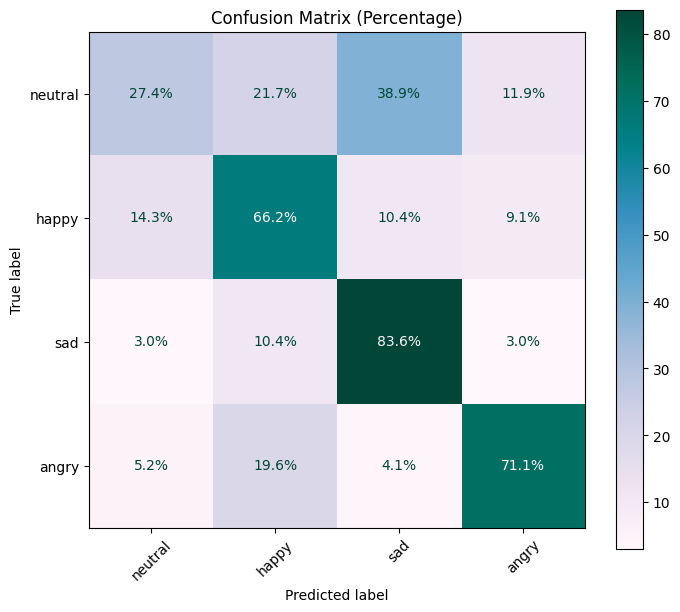

In [28]:
labels, predictions = compute_results('cairocode/IEMO_007_NOSPLIT', split_name='train', speaker_filters=[937])


[0 1 2 3]
MAXIMUM label:  3
Accuracy: 37.34290843806104
UAR: 44.64046682398423
F1 Score: 36.51196478242299
37.34290843806104 	 44.64046682398423
Confusion matrix saved to: /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LOSO_FOLD/IEMO_006/test_[937]/results/MSPI_007_NOSPLIT_an_train_accuracy_37.34_UAR_44.64.png


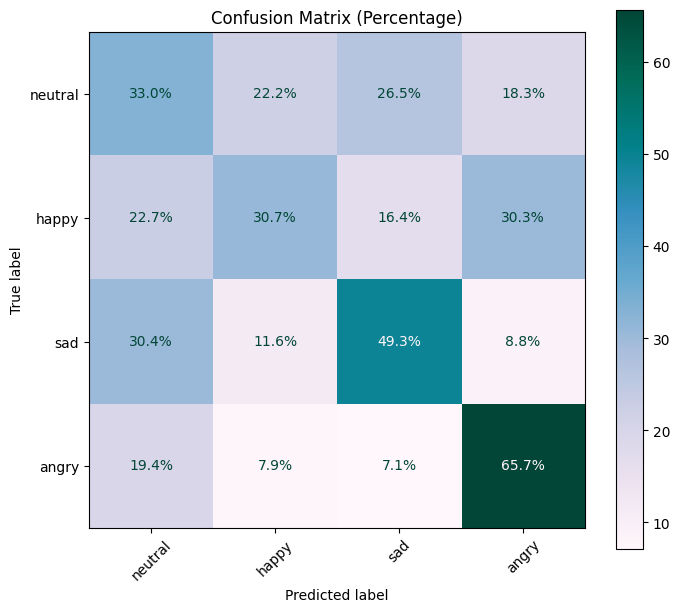

In [29]:
labels, predictions = compute_results('cairocode/MSPI_007_NOSPLIT_an', split_name='train')

[0 1 3 5]
MAXIMUM label:  3
Accuracy: 47.29020979020979
UAR: 53.048482979933176
F1 Score: 35.99437584653917
47.29020979020979 	 53.048482979933176
Confusion matrix saved to: /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/LOSO_FOLD/IEMO_006/test_[937]/results/EMOV_003_train_accuracy_47.29_UAR_53.05.png


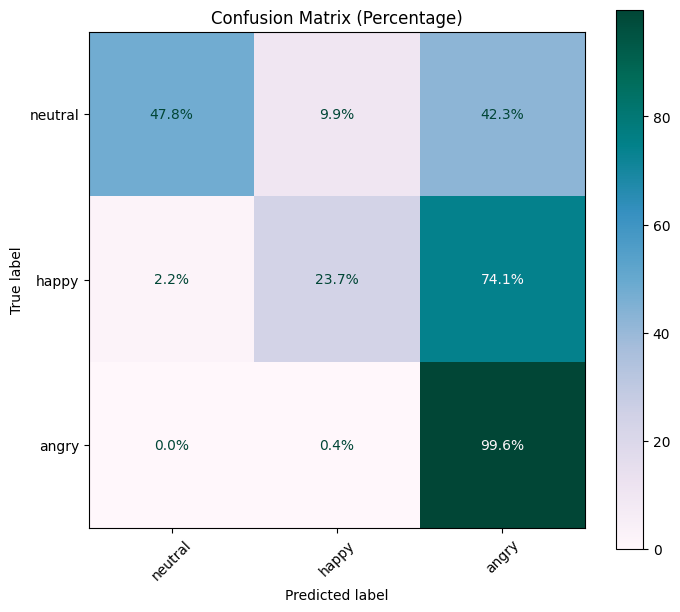

In [30]:
labels, predictions = compute_results('cairocode/EMOV_003', split_name = 'train')

In [31]:
stop

NameError: name 'stop' is not defined

In [ ]:
labels, predictions = compute_results('cairocode/BALANCED_MSPP_V6')


Generating test split: 100%|██████████| 17789/17789 [00:00<00:00, 19165.00 examples/s]


[0 1 2 3 4 5]


Filter: 100%|██████████| 17789/17789 [00:15<00:00, 1112.31 examples/s]


MAXIMUM label:  3


KeyboardInterrupt: 

[0 1 2 3 4 5]
MAXIMUM label:  3
Accuracy: 41.36200716845878
UAR: 42.032505011911425
F1 Score: 40.966888102222555
41.36200716845878 	 42.032505011911425
Confusion matrix saved to: /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSP/preliminary/RAW_DINAT/results/emo6_Test_R_train_accuracy_41.36_UAR_42.03.png


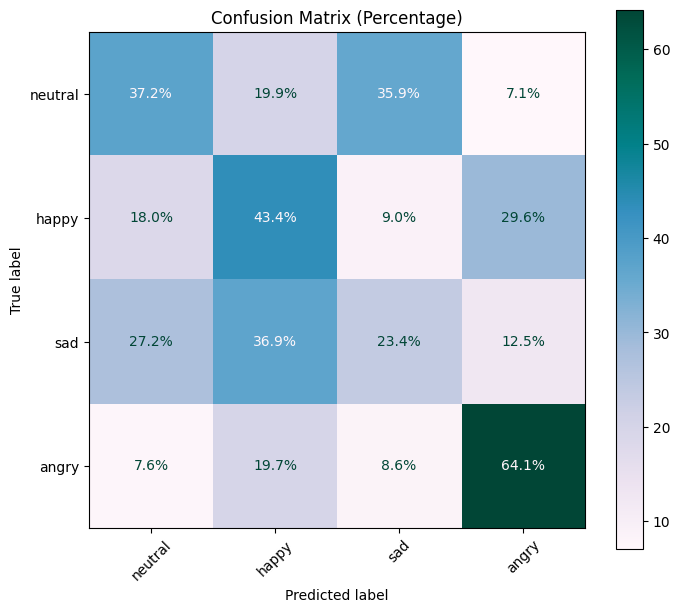

In [ ]:
labels, predictions = compute_results('cairocode/emo6_Test_R', 'train')


In [ ]:
# labels, predictions = compute_results('cairocode/CMU_MOSEI')
